In [1]:
dataset_root = "../dataset/"
images_dir = dataset_root + "complete/"
features_dir = dataset_root + 'handcrafted/'

recompute_features = False
classify_images = False

In [2]:
import sys
import cv2 as cv
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import numpy as np
sys.path.append("..")

from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from feature_extraction import build_feature_extractor
from similarity_search.neural_similarity_search import extract_features, filter_images_not_in_same_class
from handcrafted_extraction import load_all_features, load_features
import pandas as pd

extracted_features_root = "./extracted_features/"
extracted_features_path = extracted_features_root + 'efficient_net_similarity'
predictions_path = extracted_features_root + 'predictions.pickle'

#model = keras.models.load_model('../classification/tuned_models/efficientnet_v2_cosine')

def builder():
    model = keras.models.load_model('../classification/tuned_models/efficientnet_v2_cosine')
    return keras.Sequential(model.layers[:-1])


def builder_base_efficient_net():
    return build_feature_extractor(EfficientNetV2B0, 'block6h_se_reduce')

predictions = pd.read_pickle(predictions_path)

2024-01-10 17:40:44.529721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 17:40:44.529756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 17:40:44.559703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 17:40:44.618719: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 17:40:45.787450: W tensorflow/compiler/tf2

In [3]:
(handcrafted_features, _) = load_all_features(features_dir, os.listdir(images_dir), load_color=True, load_lbp=True, load_gabor=False, load_sift=False, load_bow=False)

  0%|          | 4/130469 [00:00<01:21, 1593.13it/s]


No color features found


  0%|          | 4/130469 [00:00<01:05, 2004.93it/s]

No lbp features found


In [4]:
features_tuned = np.load(extracted_features_root + 'efficient_net_similarity.npy')
features_base = np.load(extracted_features_root + 'efficient_net_not_tuned_similarity.npy')
filenames_tuned = pd.read_csv(extracted_features_root + 'efficient_net_similarity_filenames.csv', header=None).iloc[:, 1].values
filenames_base = pd.read_csv(extracted_features_root + 'efficient_net_not_tuned_similarity_filenames.csv', header=None).iloc[:, 1].values

files = os.listdir(images_dir);

## Similar images

In [14]:
## settings
use_nn = True
use_intersection = False
intersect_with_classes = False
images_to_consider = 1000

In [11]:
from similarity_search.neural_similarity_search import find_similar, find_similar_handcrafted
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist

def find_similar(features_extractors, query_image_path, database_features, database_names, preprocessing, weights, norm=True,
                 output_number=10):

    weights = np.array(weights)
    assert(weights.sum() == 1);
    ref_names = database_names[0];
    distances = []

    for model, db_fe in zip(features_extractors, database_features):
        model = model()
        if norm:
            db_fe = normalize(db_fe)

        #aligning all features order to same name order
        #order = [ref_names.tolist().index(name) for name in db_name]
        #model = model[order]
        #db_fe = db_fe[order]
        #db_name = db_name[order]

        query_image = cv.imread(query_image_path)[:, :, ::-1];
        query_image = cv.resize(query_image, (model.input_shape[1], model.input_shape[2]));
        query_image = preprocessing(query_image);
        query_image = np.expand_dims(query_image, 0);

        extracted_query = model.predict(query_image)
        if norm:
            extracted_query = normalize(extracted_query)

        distance = cdist(extracted_query, db_fe, 'cosine')[0]
        print(distance, len(distance))
        distances.append(distance);
        del model

    distances = np.array(distances);
    distance = np.matmul(weights, distances);

    most_similar_indices = np.argsort(distance)[0:output_number];
    return ref_names[most_similar_indices], distance[most_similar_indices];


def compute_most_similar(query_path, tuned_importance = 0.5):
    models = [builder, builder_base_efficient_net]
    extracted_features = [features_tuned, features_base]
    filenames = [filenames_tuned, filenames_base]
    nn_most_similar, distances = find_similar(models, query_path, extracted_features, filenames, preprocess_input, weights=[tuned_importance, 1 - tuned_importance], output_number=images_to_consider)
    if not use_nn or use_intersection:
        handcrafted_most_similar, distances = find_similar_handcrafted(images_dir, handcrafted_features, query_path, False, output_number=images_to_consider)

    if use_intersection:
        intersection = np.intersect1d(handcrafted_most_similar, nn_most_similar)
        print('Images on which handcrafted and nn agree: ', len(intersection), 'over', images_to_consider)

    most_similar_filenames = nn_most_similar if use_nn else handcrafted_most_similar
    most_similar_filenames = intersection if use_intersection else most_similar_filenames

    print(intersect_with_classes)
    if intersect_with_classes:
        most_similar_filenames = filter_images_not_in_same_class(predictions, model, preprocess_input, str(query_path), most_similar_filenames, 0.7)

    return most_similar_filenames


## Query image
(the visualized image is used in the search phase)

1/1 [==============================] - 2s 2s/step
[0.93540865 1.09588309 1.03577359 ... 1.00618918 1.0123518  1.02707718] 130469
1/1 [==============================] - 1s 1s/step
[0.31708634 0.6502839  0.83099774 ... 0.69419927 0.58741162 0.39373412] 130469
False


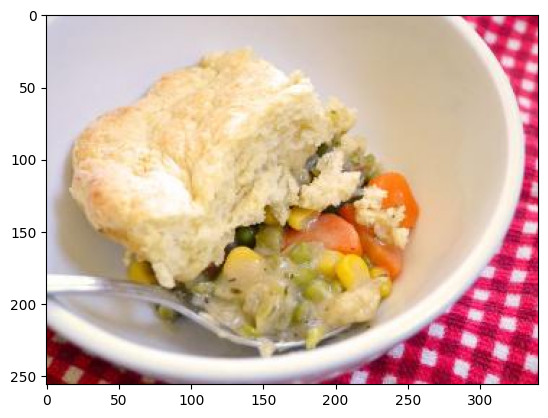

In [23]:
index = 6#np.random.randint(len(files), size=1)[0]
query_path = images_dir + files[index]

query_img = cv.imread(query_path)
query_img = cv.cvtColor(query_img, cv.COLOR_BGR2RGB);

plt.imshow(query_img);
similar_index = 0;
most_similar_filenames = compute_most_similar(query_path, tuned_importance=0.5)

## iterate over one image at step

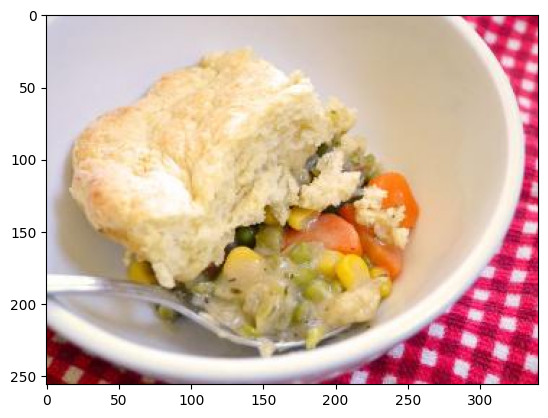

In [19]:
img = cv.imread(images_dir + most_similar_filenames[similar_index])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB);

plt.imshow(img)
similar_index += 1

## create collage

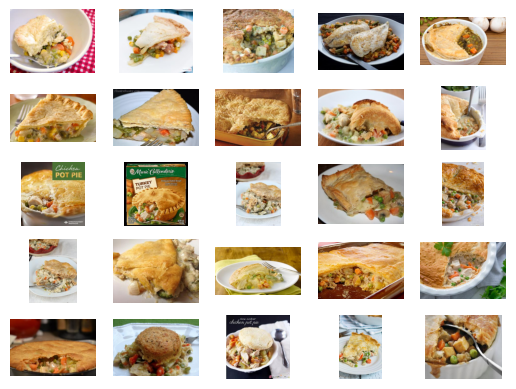

In [24]:
from misc import create_collage_with_random_imgs

create_collage_with_random_imgs(images_dir, None, 5, most_similar_filenames, False)